<a href="https://colab.research.google.com/github/SEAS-CVN/SEAS-2025/blob/central-region-nlp/Projects/Central_Region_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install & Import libraries

Restart session after installation

In [3]:
!pip install fsspec==2023.9.2
!pip install -q transformers accelerate datasets evaluate jiwer
!pip install librosa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2023.9.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64

In [3]:
import evaluate
from google.colab import drive
from datasets import load_dataset, Dataset, load_from_disk, concatenate_datasets, Audio
from pathlib import Path
import librosa
import matplotlib.pyplot as plt
import os
import math
from typing import Literal, Any, Dict, List, Union
import pandas as pd
import numpy as np
from transformers import AutoProcessor, AutoModelForSpeechSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer, TrainerControl, TrainerCallback, GenerationConfig
from dataclasses import dataclass
import torch
from IPython.display import Audio
import multiprocessing

# I. Data Preparation

In [4]:
# Mount Google Drive, log in to your Drive via window pop up
drive.mount('/content/drive')

# Define the Google Drive path for saving data
SAVE_PATH = '/content/drive/MyDrive/ViMD_downsampled_16Hz_16fp'
PHOWHISPER_OUTPUT_PATH = "/content/drive/MyDrive/phowhisper-vimd-ft_2"
CHUNKFORMER_OUTPUT_PATH = "/content/drive/MyDrive/chunkformer-ft"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### (Optional) Stream and Preprocess Dataset from Hugging Face

Since the full dataset is too large to download and save, we will use a method called [streaming](https://huggingface.co/docs/datasets/stream). Streaming allows us to iterate over a large dataset one example at a time without downloading the entire file into memory. We use this approach to iterate over the data and just save a 'lighter' version of each data sample.In particular, we'll save audio with smaller audio sampling rate (from `48000` to `16000`) and save the audio array in smaller floating point representation (from `float64` to `float16`)

In [ ]:
def resample_audio(audio_dict, target_sr=16000):
    original_sr = audio_dict["sampling_rate"]
    if original_sr == target_sr:
        return audio_dict
    y = np.asarray(audio_dict["array"])
    y_resampled = librosa.resample(y, orig_sr=original_sr, target_sr=target_sr)
    return {
        "array": y_resampled.astype(np.float16), #original float64
        "sampling_rate": target_sr,
        "path": audio_dict.get("path", None)
    }

In [ ]:
def save_dataset_in_chunks(split: Literal['train','valid','test'], save_path: str):
    """
    Save a dataset in chunks to disk by region.
    Data is streamed once and distributed to North/Central/South folders based on region.

    Args:
        split (str): Dataset split to load ('train', 'valid', 'test')
        save_path (str): Base path where regional folders will be created
    """
    # Setup regional folders
    regions = ['North', 'Central', 'South']
    region_paths = {}
    region_buffers = {}
    region_chunk_indices = {}

    CHUNK_SIZE = 300

    # Initialize for each region
    for region in regions:
        region_path = os.path.join(save_path, region, split)
        region_paths[region] = region_path
        Path(region_path).mkdir(parents=True, exist_ok=True)

        # Initialize buffers and chunk indices
        region_buffers[region] = []
        region_chunk_indices[region] = 0

    # Stream the dataset once and distribute by region
    streamed_dataset = load_dataset("nguyendv02/ViMD_Dataset", split=split, streaming=True)

    for example in streamed_dataset:
        region = example.get("region")
        if region in regions:
            # Process audio and add to appropriate region buffer
            example["audio"] = resample_audio(example["audio"])
            region_buffers[region].append(example)

            # Check if buffer is full and save chunk
            if len(region_buffers[region]) >= CHUNK_SIZE:
                chunk_idx = region_chunk_indices[region]
                chunk_path = os.path.join(region_paths[region], f"chunk_{chunk_idx}")
                Dataset.from_list(region_buffers[region]).save_to_disk(chunk_path)
                print(f"Saved {region} chunk {chunk_idx} with {len(region_buffers[region])} examples")

                region_buffers[region] = []
                region_chunk_indices[region] += 1

    # Save any remaining data in buffers (final partial chunks)
    for region in regions:
        if region_buffers[region]:
            chunk_idx = region_chunk_indices[region]
            chunk_path = os.path.join(region_paths[region], f"chunk_{chunk_idx}")
            Dataset.from_list(region_buffers[region]).save_to_disk(chunk_path)
            print(f"Saved final {region} chunk {chunk_idx} with {len(region_buffers[region])} examples")

In [ ]:
# save_dataset_in_chunks("train", SAVE_PATH)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Repo card metadata block was not found. Setting CardData to empty.


Resolving data files:   0%|          | 0/103 [00:00<?, ?it/s]

Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved North chunk 0 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved North chunk 1 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved North chunk 2 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved North chunk 3 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved North chunk 4 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved North chunk 5 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved North chunk 6 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved North chunk 7 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved North chunk 8 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved North chunk 9 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved North chunk 10 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved North chunk 11 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved North chunk 12 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved North chunk 13 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved North chunk 14 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved Central chunk 0 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved Central chunk 1 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved Central chunk 2 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved Central chunk 3 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved Central chunk 4 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved South chunk 0 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved South chunk 1 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved South chunk 2 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved South chunk 3 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved South chunk 4 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved South chunk 5 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved South chunk 6 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved South chunk 7 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved South chunk 8 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved South chunk 9 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved Central chunk 5 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved Central chunk 6 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved Central chunk 7 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved Central chunk 8 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved Central chunk 9 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved Central chunk 10 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved Central chunk 11 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved Central chunk 12 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved South chunk 10 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved South chunk 11 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved Central chunk 13 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved North chunk 15 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved North chunk 16 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved Central chunk 14 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved South chunk 12 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved South chunk 13 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved North chunk 17 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved North chunk 18 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/213 [00:00<?, ? examples/s]

Saved final North chunk 19 with 213 examples


Saving the dataset (0/1 shards):   0%|          | 0/205 [00:00<?, ? examples/s]

Saved final Central chunk 15 with 205 examples


Saving the dataset (0/1 shards):   0%|          | 0/205 [00:00<?, ? examples/s]

Saved final South chunk 14 with 205 examples


In [ ]:
# save_dataset_in_chunks("valid", SAVE_PATH)

Repo card metadata block was not found. Setting CardData to empty.


Resolving data files:   0%|          | 0/103 [00:00<?, ?it/s]

Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved North chunk 0 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved South chunk 0 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved Central chunk 0 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved North chunk 1 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved Central chunk 1 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/152 [00:00<?, ? examples/s]

Saved final North chunk 2 with 152 examples


Saving the dataset (0/1 shards):   0%|          | 0/2 [00:00<?, ? examples/s]

Saved final Central chunk 2 with 2 examples


Saving the dataset (0/1 shards):   0%|          | 0/246 [00:00<?, ? examples/s]

Saved final South chunk 1 with 246 examples


In [ ]:
# save_dataset_in_chunks("test", SAVE_PATH)

Repo card metadata block was not found. Setting CardData to empty.


Resolving data files:   0%|          | 0/103 [00:00<?, ?it/s]

Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved North chunk 0 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved North chunk 1 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved South chunk 0 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved Central chunk 0 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved Central chunk 1 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/300 [00:00<?, ? examples/s]

Saved South chunk 1 with 300 examples


Saving the dataset (0/1 shards):   0%|          | 0/183 [00:00<?, ? examples/s]

Saved final North chunk 2 with 183 examples


Saving the dataset (0/1 shards):   0%|          | 0/23 [00:00<?, ? examples/s]

Saved final Central chunk 2 with 23 examples


Saving the dataset (0/1 shards):   0%|          | 0/20 [00:00<?, ? examples/s]

Saved final South chunk 2 with 20 examples


### Load Dataset

TODO: Guide students to wget or download our preprocessed dataset

In [5]:
def load_dataset_chunks(region: Literal['North', 'Central', 'South'], save_path: str):
    """
    Load and combine all chunks for a specific region across all splits.

    Args:
        region (str): Region to load ('North', 'Central', 'South')
        save_path (str): Main path where regional folders are located

    Returns:
        dict: Dictionary with keys 'train', 'valid', 'test' containing combined datasets
    """
    region_path = os.path.join(save_path, region)
    splits = ['train', 'valid', 'test']
    region_datasets = {}

    for split in splits:
        split_path = os.path.join(region_path, split)
        all_chunks = []

        if Path(split_path).exists():
            for chunk_dir in sorted(Path(split_path).glob("chunk_*")):
                if chunk_dir.is_dir():
                    print(f"Loading {region} {split} {chunk_dir.name}")
                    all_chunks.append(load_from_disk(str(chunk_dir)))

            if all_chunks:
                # Combine into a single Dataset
                combined_dataset = concatenate_datasets(all_chunks)
                print(f"{region} {split} total examples: {len(combined_dataset)}")
                region_datasets[split] = combined_dataset
            else:
                print(f"No chunks found for {region} {split}")
                region_datasets[split] = None
        else:
            print(f"Split path does not exist: {split_path}")
            region_datasets[split] = None

    return region_datasets

In [6]:
north_dataset = load_dataset_chunks("North", SAVE_PATH)
central_dataset = load_dataset_chunks("Central", SAVE_PATH)
south_dataset = load_dataset_chunks("South", SAVE_PATH)

Loading North train chunk_0
Loading North train chunk_1
Loading North train chunk_10
Loading North train chunk_11
Loading North train chunk_12
Loading North train chunk_13
Loading North train chunk_14
Loading North train chunk_15
Loading North train chunk_16
Loading North train chunk_17
Loading North train chunk_18
Loading North train chunk_19
Loading North train chunk_2
Loading North train chunk_3
Loading North train chunk_4
Loading North train chunk_5
Loading North train chunk_6
Loading North train chunk_7
Loading North train chunk_8
Loading North train chunk_9
North train total examples: 5913
Loading North valid chunk_0
Loading North valid chunk_1
Loading North valid chunk_2
North valid total examples: 752
Loading North test chunk_0
Loading North test chunk_1
Loading North test chunk_2
North test total examples: 783
Loading Central train chunk_0
Loading Central train chunk_1
Loading Central train chunk_10
Loading Central train chunk_11
Loading Central train chunk_12
Loading Central 

### Data Analysis

In [7]:
central_dataset['train'].features

{'region': Value(dtype='string', id=None),
 'province_code': Value(dtype='int64', id=None),
 'province_name': Value(dtype='string', id=None),
 'filename': Value(dtype='string', id=None),
 'text': Value(dtype='string', id=None),
 'speakerID': Value(dtype='string', id=None),
 'gender': Value(dtype='int64', id=None),
 'audio': {'array': Sequence(feature=Value(dtype='float16', id=None), length=-1, id=None),
  'path': Value(dtype='string', id=None),
  'sampling_rate': Value(dtype='int64', id=None)}}

In [9]:
train_dataset, valid_dataset, test_dataset = central_dataset['train'], central_dataset['valid'], central_dataset['test']

In [ ]:
audio_array = train_dataset[0]['audio']['array']
sampling_rate = train_dataset[0]['audio']['sampling_rate']
print("Sampling Rate:",sampling_rate)
duration = len(audio_array) / sampling_rate
print(f"Duration: {duration:.2f} seconds")

Sampling Rate: 16000
Duration: 21.40 seconds


In [ ]:
# can convert to pandas dataframe for easier analysis
train_df = central_dataset['train'].to_pandas()

In [ ]:
train_df.head()

,region,province_code,province_name,filename,text,speakerID,gender,audio
0,Central,36,ThanhHoa,36_0001.wav,Rất là tiện đấy ạ. thí dụ như là tôi muốn về t...,spk_36_0001,0,"{'array': [-0.004215, -0.007328, -0.005314, -0..."
1,Central,36,ThanhHoa,36_0002.wav,Kiến nghị với các cơ quan chức năng nhà nước c...,spk_36_0002,1,"{'array': [0.001575, 0.00314, 0.00294, 0.00301..."
2,Central,36,ThanhHoa,36_0003.wav,Mình cũng đề nghị với các cấp các ngành tìm ra...,spk_36_0003,1,"{'array': [-0.001329, -0.002783, 0.000412, 0.0..."
3,Central,36,ThanhHoa,36_0004.wav,"Hiện nay, thì một số cơ sở dịch vụ thẩm mỹ hoặ...",spk_36_0004,1,"{'array': [0.012955, 0.00402, -0.01261, -0.010..."
4,Central,36,ThanhHoa,36_0005.wav,Tuy nhiên đâu đó cũng đang còn chưa dứt điểm B...,spk_36_0004,1,"{'array': [0.001908, 0.003462, 0.002922, 0.002..."


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4705 entries, 0 to 4704
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   region         4705 non-null   object
 1   province_code  4705 non-null   int64 
 2   province_name  4705 non-null   object
 3   filename       4705 non-null   object
 4   text           4705 non-null   object
 5   speakerID      4705 non-null   object
 6   gender         4705 non-null   int64 
 7   audio          4705 non-null   object
dtypes: int64(2), object(6)
memory usage: 294.2+ KB


In [ ]:
audio_lengths = train_df['audio'].apply(lambda x: len(x['array']))
durations = audio_lengths / sampling_rate
print(f"Average duration: {durations.mean():.2f} seconds")

Average duration: 19.11 seconds


### BONUS: Compare frequency between different regions

TODO: documentation theory part

In [11]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

def get_random_samples(dataset, n_samples=50, random_seed=42):
    """Get exactly n_samples random samples from dataset (works with HuggingFace datasets)"""
    random.seed(random_seed)
    shuffled = dataset.shuffle(seed=random_seed)
    return shuffled.select(range(n_samples))

def extract_audio_features_fast(audio_data, sr=16000, debug=True):
    """Extract basic audio features with optimizations for speed"""
    if debug:
        print(f"    Starting feature extraction for audio of length {len(audio_data)}")

    # Convert to numpy array first
    audio_data = np.array(audio_data, dtype=np.float32)

    # Convert to mono if stereo
    if len(audio_data.shape) > 1:
        if debug:
            print(f"    Converting stereo to mono...")
        audio_data = librosa.to_mono(audio_data.T)

    # Skip very short audio
    if len(audio_data) < 512:
        if debug:
            print(f"    Skipping short audio (length: {len(audio_data)})")
        return {'dominant_frequency': 0.0, 'f0_mean': 0.0, 'spectral_centroid': 0.0}

    # # OPTIMIZATION 1: Downsample for faster processing (voice analysis doesn't need full bandwidth)
    # target_sr = 8000  # Sufficient for voice analysis (human voice is ~85-255 Hz fundamental)
    # if sr > target_sr:
    #     audio_data = librosa.resample(audio_data, orig_sr=sr, target_sr=target_sr)
    #     sr = target_sr
    #     if debug:
    #         print(f"    Downsampled to {sr} Hz, new length: {len(audio_data)}")

    # OPTIMIZATION 2: Use only middle portion of audio (avoid silence at start/end)
    # Take middle portion or max 5 seconds
    max_samples = min(len(audio_data), 5 * sr)  # Max 5 seconds
    start_idx = max(0, (len(audio_data) - max_samples) // 2)
    end_idx = start_idx + max_samples
    audio_data = audio_data[start_idx:end_idx]

    if debug:
        print(f"    Using middle portion: {len(audio_data)} samples ({len(audio_data)/sr:.1f}s)")

    # Normalize audio
    audio_data = np.clip(audio_data, -1.0, 1.0)

    try:
        # OPTIMIZATION 3: Use librosa's built-in pitch detection (much faster)
        if debug:
            print(f"    Computing pitch using librosa...")

        # Use librosa's piptrack for fundamental frequency estimation
        pitches, magnitudes = librosa.piptrack(y=audio_data, sr=sr,
                                             fmin=80, fmax=400,  # Human voice range
                                             threshold=0.1)

        # Extract fundamental frequency
        pitch_values = []
        for t in range(pitches.shape[1]):
            index = magnitudes[:, t].argmax()
            pitch = pitches[index, t]
            if pitch > 0:
                pitch_values.append(pitch)

        f0_mean = np.mean(pitch_values) if pitch_values else 0.0

        # OPTIMIZATION 4: Faster spectral centroid calculation
        if debug:
            print(f"    Computing spectral centroid...")
        spectral_centroids = librosa.feature.spectral_centroid(y=audio_data, sr=sr)[0]

        # OPTIMIZATION 5: Simplified dominant frequency using peak finding
        if debug:
            print(f"    Computing dominant frequency...")

        # Use shorter FFT for speed
        n_fft = min(2048, len(audio_data))
        fft_result = np.fft.rfft(audio_data, n=n_fft)
        magnitude = np.abs(fft_result)
        frequencies = np.fft.rfftfreq(n_fft, 1/sr)

        # Focus on speech frequency range (80-400 Hz)
        speech_mask = (frequencies >= 80) & (frequencies <= 400)
        if np.any(speech_mask):
            speech_freqs = frequencies[speech_mask]
            speech_mags = magnitude[speech_mask]
            dominant_freq = speech_freqs[np.argmax(speech_mags)]
        else:
            dominant_freq = 0.0

        if debug:
            print(f"    Feature extraction complete")
            print(f"    F0 mean: {f0_mean:.1f} Hz, Dominant: {dominant_freq:.1f} Hz")

        return {
            'dominant_frequency': float(dominant_freq),
            'f0_mean': float(f0_mean),
            'spectral_centroid': float(np.mean(spectral_centroids))
        }

    except Exception as e:
        print(f"Error processing audio: {e}")
        return {'dominant_frequency': 0.0, 'f0_mean': 0.0, 'spectral_centroid': 0.0}

def analyze_regions(north_dataset, central_dataset, south_dataset, n_samples=50, debug=True):
    """Analyze audio features from 3 regional datasets with speed optimizations"""

    # Get random samples from each dataset
    print(f"Sampling {n_samples} files from each region...")

    print("  Getting random samples from North dataset...")
    north_sampled = get_random_samples(north_dataset, n_samples)
    print(f"  North: {len(north_sampled)} samples selected")

    print("  Getting random samples from Central dataset...")
    central_sampled = get_random_samples(central_dataset, n_samples)
    print(f"  Central: {len(central_sampled)} samples selected")

    print("  Getting random samples from South dataset...")
    south_sampled = get_random_samples(south_dataset, n_samples)
    print(f"  South: {len(south_sampled)} samples selected")

    regions = {
        'North': north_sampled,
        'Central': central_sampled,
        'South': south_sampled
    }

    results = {}

    for region_name, dataset in regions.items():
        print(f"\n{'='*60}")
        print(f"Processing {region_name} ({len(dataset)} files)...")
        print(f"{'='*60}")

        all_features = []

        # Process each audio file
        for i, audio_item in enumerate(tqdm(dataset, desc=f"Processing {region_name}")):
            try:
                if debug and i < 3:  # Debug first 3 files
                    print(f"\n  Processing file {i+1}/{len(dataset)}")

                audio_data = audio_item['audio']['array']
                sr = audio_item['audio']['sampling_rate']

                if audio_data is None or len(audio_data) == 0:
                    print(f"  Skipping empty audio file {i+1}")
                    continue

                # Convert to numpy array
                audio_data = np.array(audio_data)

                if debug and i < 3:
                    print(f"  Audio shape: {audio_data.shape}, Sample rate: {sr}")

                features = extract_audio_features_fast(audio_data, sr, debug=(debug and i < 3))
                all_features.append(features)

                if debug and i < 3:
                    print(f"  Features extracted: {features}")

            except Exception as e:
                print(f"  ERROR processing file {i+1}: {e}")
                continue

        print(f"\nFeature extraction complete for {region_name}")
        print(f"Successfully processed {len(all_features)} out of {len(dataset)} files")

        # Calculate averages
        if all_features:
            print(f"Computing statistics for {region_name}...")
            dominant_freqs = [f['dominant_frequency'] for f in all_features if f['dominant_frequency'] > 0]
            f0_values = [f['f0_mean'] for f in all_features if f['f0_mean'] > 0]
            centroids = [f['spectral_centroid'] for f in all_features if f['spectral_centroid'] > 0]

            print(f"  Valid dominant frequencies: {len(dominant_freqs)}")
            print(f"  Valid F0 values: {len(f0_values)}")
            print(f"  Valid spectral centroids: {len(centroids)}")

            results[region_name] = {
                'avg_dominant_freq': np.mean(dominant_freqs) if dominant_freqs else 0,
                'avg_f0': np.mean(f0_values) if f0_values else 0,
                'avg_spectral_centroid': np.mean(centroids) if centroids else 0,
                'dominant_freqs': dominant_freqs,
                'f0_values': f0_values,
                'spectral_centroids': centroids,
                'total_processed': len(all_features)
            }

    print(f"\n{'='*60}")
    print("All regions processed! Creating plots...")
    create_plots_fast(results)
    print("Creating summary...")
    print_results_fast(results)

    return results

def create_plots_fast(results):
    """Create comparison plots focused on voice characteristics"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Phân tích đặc trưng giọng nói theo vùng miền', fontsize=16, fontweight='bold')

    regions = list(results.keys())
    colors = ['#2E86AB', '#A23B72', '#F18F01']

    # Average comparisons
    dom_freqs = [results[r]['avg_dominant_freq'] for r in regions]
    f0_values = [results[r]['avg_f0'] for r in regions]
    centroids = [results[r]['avg_spectral_centroid'] for r in regions]

    # Bar plots
    axes[0, 0].bar(regions, dom_freqs, color=colors, alpha=0.8)
    axes[0, 0].set_title('Tần số trội (Hz)\n(Dominant Frequency)')
    axes[0, 0].set_ylabel('Tần số (Hz)')
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].bar(regions, f0_values, color=colors, alpha=0.8)
    axes[0, 1].set_title('Tần số cơ bản trung bình (Hz)\n(Average F0 - Cao độ giọng nói)')
    axes[0, 1].set_ylabel('Tần số (Hz)')
    axes[0, 1].grid(True, alpha=0.3)

    axes[0, 2].bar(regions, centroids, color=colors, alpha=0.8)
    axes[0, 2].set_title('Trọng tâm phổ (Hz)\n(Spectral Centroid)')
    axes[0, 2].set_ylabel('Tần số (Hz)')
    axes[0, 2].grid(True, alpha=0.3)

    # Distribution plots
    for i, region in enumerate(regions):
        if results[region]['dominant_freqs']:
            axes[1, 0].hist(results[region]['dominant_freqs'], bins=15, alpha=0.7,
                           label=region, color=colors[i], edgecolor='black', linewidth=0.5)
        if results[region]['f0_values']:
            axes[1, 1].hist(results[region]['f0_values'], bins=15, alpha=0.7,
                           label=region, color=colors[i], edgecolor='black', linewidth=0.5)
        if results[region]['spectral_centroids']:
            axes[1, 2].hist(results[region]['spectral_centroids'], bins=15, alpha=0.7,
                           label=region, color=colors[i], edgecolor='black', linewidth=0.5)

    axes[1, 0].set_title('Phân bố tần số trội')
    axes[1, 0].set_xlabel('Tần số (Hz)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].set_title('Phân bố tần số cơ bản\n(Trầm - Bổng)')
    axes[1, 1].set_xlabel('Tần số cơ bản (Hz)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    axes[1, 2].set_title('Phân bố trọng tâm phổ')
    axes[1, 2].set_xlabel('Trọng tâm phổ (Hz)')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def print_results_fast(results):
    """Print summary results with voice analysis focus"""
    print("\n" + "="*60)
    print("KẾT QUẢ PHÂN TÍCH ĐặC TRƯNG GIỌNG NÓI THEO VÙNG MIỀN")
    print("="*60)

    # Sort regions by F0 to see which is higher/lower
    sorted_regions = sorted(results.keys(), key=lambda x: results[x]['avg_f0'], reverse=True)

    for i, region in enumerate(sorted_regions):
        r = results[region]
        print(f"\n{region.upper()} ({'Trầm nhất' if i == len(sorted_regions)-1 else 'Bổng nhất' if i == 0 else 'Trung bình'}):")
        print(f"  Tần số cơ bản (F0): {r['avg_f0']:.1f} Hz")
        print(f"  Tần số trội: {r['avg_dominant_freq']:.1f} Hz")
        print(f"  Trọng tâm phổ: {r['avg_spectral_centroid']:.1f} Hz")
        print(f"  Số file xử lý: {r['total_processed']}")

    print(f"\n{'='*60}")
    print("NHẬN XÉT:")
    highest_f0 = max(results.keys(), key=lambda x: results[x]['avg_f0'])
    lowest_f0 = min(results.keys(), key=lambda x: results[x]['avg_f0'])
    print(f"- Giọng {highest_f0} có tần số cơ bản cao nhất (bổng nhất): {results[highest_f0]['avg_f0']:.1f} Hz")
    print(f"- Giọng {lowest_f0} có tần số cơ bản thấp nhất (trầm nhất): {results[lowest_f0]['avg_f0']:.1f} Hz")

    f0_diff = results[highest_f0]['avg_f0'] - results[lowest_f0]['avg_f0']
    print(f"- Chênh lệch tần số: {f0_diff:.1f} Hz")

    if f0_diff > 10:
        print("- Có sự khác biệt đáng kể về cao độ giọng nói giữa các vùng miền")
    else:
        print("- Sự khác biệt về cao độ giọng nói giữa các vùng miền không nhiều")

Sampling 30 files from each region...
  Getting random samples from North dataset...
  North: 30 samples selected
  Getting random samples from Central dataset...
  Central: 30 samples selected
  Getting random samples from South dataset...
  South: 30 samples selected

Processing North (30 files)...


Processing North:   3%|▎         | 1/30 [00:00<00:07,  3.86it/s]


  Processing file 1/30
  Audio shape: (277714,), Sample rate: 16000
    Starting feature extraction for audio of length 277714
    Using middle portion: 80000 samples (5.0s)
    Computing pitch using librosa...
    Computing spectral centroid...
    Computing dominant frequency...
    Feature extraction complete
    F0 mean: 198.6 Hz, Dominant: 218.8 Hz
  Features extracted: {'dominant_frequency': 218.75, 'f0_mean': 198.6011199951172, 'spectral_centroid': 1863.5582730059932}


Processing North:   7%|▋         | 2/30 [00:00<00:11,  2.54it/s]


  Processing file 2/30
  Audio shape: (446448,), Sample rate: 16000
    Starting feature extraction for audio of length 446448
    Using middle portion: 80000 samples (5.0s)
    Computing pitch using librosa...
    Computing spectral centroid...
    Computing dominant frequency...
    Feature extraction complete
    F0 mean: 222.1 Hz, Dominant: 164.1 Hz
  Features extracted: {'dominant_frequency': 164.0625, 'f0_mean': 222.09225463867188, 'spectral_centroid': 1389.3419578919554}


Processing North:  10%|█         | 3/30 [00:01<00:12,  2.22it/s]


  Processing file 3/30
  Audio shape: (375280,), Sample rate: 16000
    Starting feature extraction for audio of length 375280
    Using middle portion: 80000 samples (5.0s)
    Computing pitch using librosa...
    Computing spectral centroid...
    Computing dominant frequency...
    Feature extraction complete
    F0 mean: 248.3 Hz, Dominant: 242.2 Hz
  Features extracted: {'dominant_frequency': 242.1875, 'f0_mean': 248.30239868164062, 'spectral_centroid': 1213.899125244234}


Processing North: 100%|██████████| 30/30 [00:10<00:00,  2.88it/s]



Feature extraction complete for North
Successfully processed 30 out of 30 files
Computing statistics for North...
  Valid dominant frequencies: 30
  Valid F0 values: 30
  Valid spectral centroids: 30

Processing Central (30 files)...


Processing Central:   3%|▎         | 1/30 [00:00<00:05,  5.60it/s]


  Processing file 1/30
  Audio shape: (293233,), Sample rate: 16000
    Starting feature extraction for audio of length 293233
    Using middle portion: 80000 samples (5.0s)
    Computing pitch using librosa...
    Computing spectral centroid...
    Computing dominant frequency...
    Feature extraction complete
    F0 mean: 230.6 Hz, Dominant: 234.4 Hz
  Features extracted: {'dominant_frequency': 234.375, 'f0_mean': 230.64761352539062, 'spectral_centroid': 1296.6899002298687}


Processing Central:  13%|█▎        | 4/30 [00:00<00:03,  7.14it/s]


  Processing file 2/30
  Audio shape: (349552,), Sample rate: 16000
    Starting feature extraction for audio of length 349552
    Using middle portion: 80000 samples (5.0s)
    Computing pitch using librosa...
    Computing spectral centroid...
    Computing dominant frequency...
    Feature extraction complete
    F0 mean: 268.9 Hz, Dominant: 101.6 Hz
  Features extracted: {'dominant_frequency': 101.5625, 'f0_mean': 268.866455078125, 'spectral_centroid': 1461.7426921320255}

  Processing file 3/30
  Audio shape: (183281,), Sample rate: 16000
    Starting feature extraction for audio of length 183281
    Using middle portion: 80000 samples (5.0s)
    Computing pitch using librosa...
    Computing spectral centroid...
    Computing dominant frequency...
    Feature extraction complete
    F0 mean: 196.1 Hz, Dominant: 164.1 Hz
  Features extracted: {'dominant_frequency': 164.0625, 'f0_mean': 196.14315795898438, 'spectral_centroid': 1445.599443070368}


Processing Central: 100%|██████████| 30/30 [00:07<00:00,  3.97it/s]



Feature extraction complete for Central
Successfully processed 30 out of 30 files
Computing statistics for Central...
  Valid dominant frequencies: 30
  Valid F0 values: 30
  Valid spectral centroids: 30

Processing South (30 files)...


Processing South:   0%|          | 0/30 [00:00<?, ?it/s]


  Processing file 1/30
  Audio shape: (300097,), Sample rate: 16000
    Starting feature extraction for audio of length 300097
    Using middle portion: 80000 samples (5.0s)
    Computing pitch using librosa...


Processing South:   7%|▋         | 2/30 [00:00<00:05,  5.20it/s]

    Computing spectral centroid...
    Computing dominant frequency...
    Feature extraction complete
    F0 mean: 248.9 Hz, Dominant: 226.6 Hz
  Features extracted: {'dominant_frequency': 226.5625, 'f0_mean': 248.87380981445312, 'spectral_centroid': 1134.1447577254464}

  Processing file 2/30
  Audio shape: (387040,), Sample rate: 16000
    Starting feature extraction for audio of length 387040
    Using middle portion: 80000 samples (5.0s)
    Computing pitch using librosa...
    Computing spectral centroid...
    Computing dominant frequency...
    Feature extraction complete
    F0 mean: 313.0 Hz, Dominant: 398.4 Hz
  Features extracted: {'dominant_frequency': 398.4375, 'f0_mean': 313.03973388671875, 'spectral_centroid': 1211.3701448888032}

  Processing file 3/30


Processing South:  13%|█▎        | 4/30 [00:00<00:04,  5.92it/s]

  Audio shape: (449227,), Sample rate: 16000
    Starting feature extraction for audio of length 449227
    Using middle portion: 80000 samples (5.0s)
    Computing pitch using librosa...
    Computing spectral centroid...
    Computing dominant frequency...
    Feature extraction complete
    F0 mean: 236.6 Hz, Dominant: 382.8 Hz
  Features extracted: {'dominant_frequency': 382.8125, 'f0_mean': 236.6249542236328, 'spectral_centroid': 1257.5986281653747}


Processing South: 100%|██████████| 30/30 [00:07<00:00,  3.89it/s]



Feature extraction complete for South
Successfully processed 30 out of 30 files
Computing statistics for South...
  Valid dominant frequencies: 30
  Valid F0 values: 30
  Valid spectral centroids: 30

All regions processed! Creating plots...


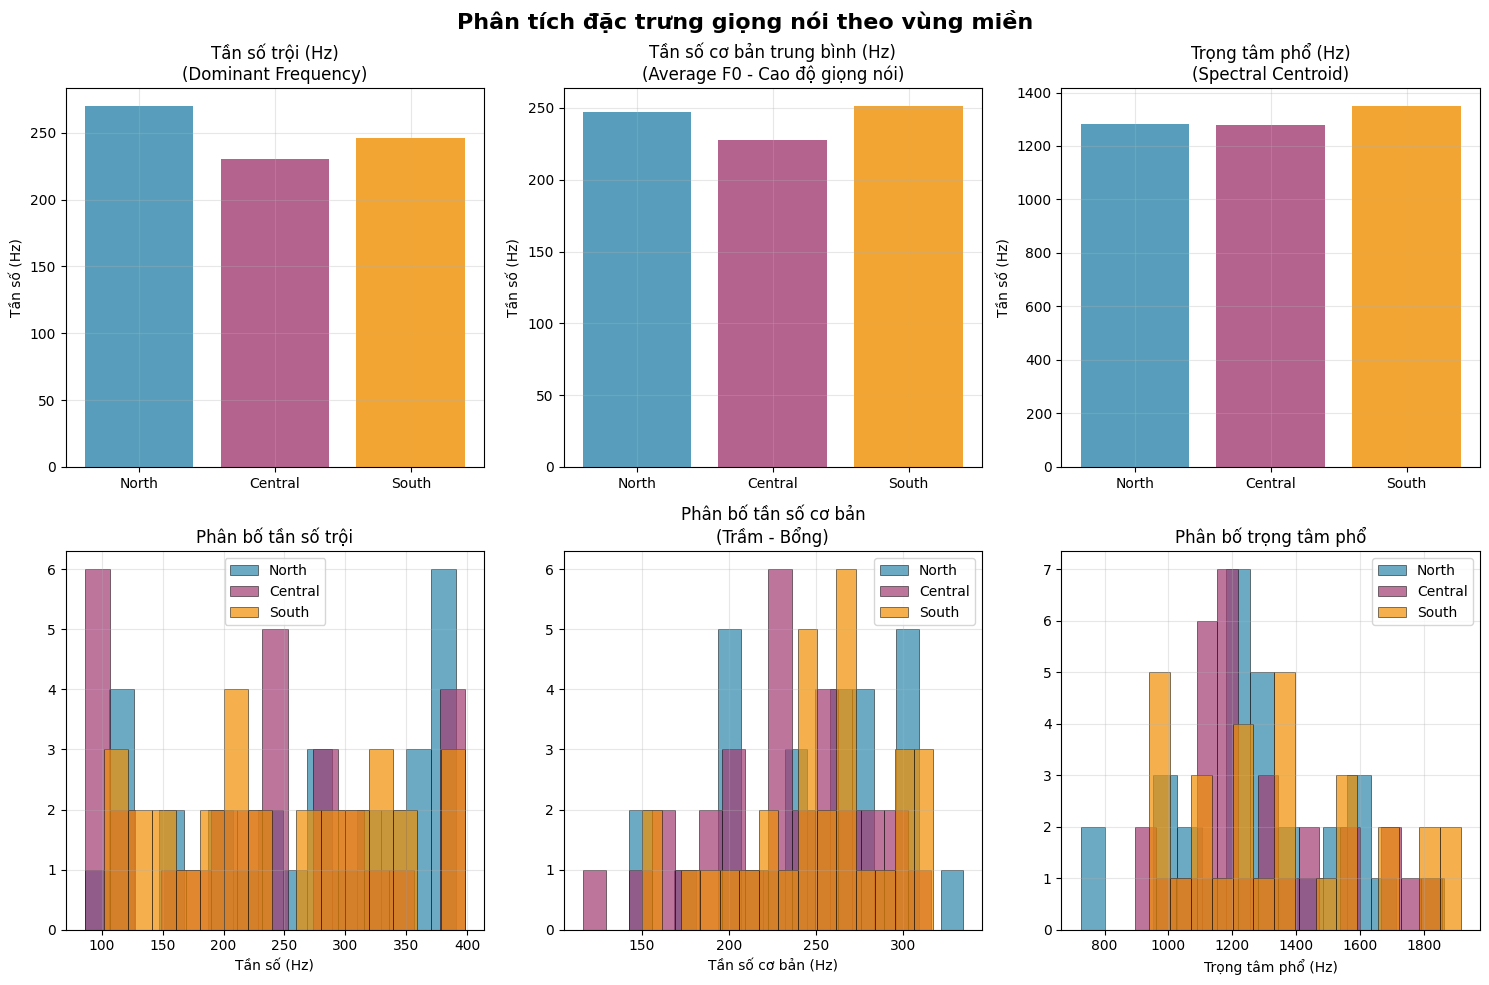

Creating summary...

KẾT QUẢ PHÂN TÍCH ĐặC TRƯNG GIỌNG NÓI THEO VÙNG MIỀN

SOUTH (Bổng nhất):
  Tần số cơ bản (F0): 251.2 Hz
  Tần số trội: 245.8 Hz
  Trọng tâm phổ: 1348.6 Hz
  Số file xử lý: 30

NORTH (Trung bình):
  Tần số cơ bản (F0): 247.1 Hz
  Tần số trội: 269.8 Hz
  Trọng tâm phổ: 1282.2 Hz
  Số file xử lý: 30

CENTRAL (Trầm nhất):
  Tần số cơ bản (F0): 227.8 Hz
  Tần số trội: 230.2 Hz
  Trọng tâm phổ: 1278.1 Hz
  Số file xử lý: 30

NHẬN XÉT:
- Giọng South có tần số cơ bản cao nhất (bổng nhất): 251.2 Hz
- Giọng Central có tần số cơ bản thấp nhất (trầm nhất): 227.8 Hz
- Chênh lệch tần số: 23.4 Hz
- Có sự khác biệt đáng kể về cao độ giọng nói giữa các vùng miền


In [12]:
comparison_results = analyze_regions(north_dataset['train'], central_dataset['train'], south_dataset['train'], n_samples=30, debug=True)

# II. Model Finetuning

### Load Pre-trained Models

Nguyen to do: introduce PhoWhisper

In [ ]:
processor = AutoProcessor.from_pretrained("vinai/PhoWhisper-base")
model = AutoModelForSpeechSeq2Seq.from_pretrained("vinai/PhoWhisper-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/339 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.20M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.08k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/290M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.77k [00:00<?, ?B/s]

### 2. Model Settings

In [ ]:
print(multiprocessing.cpu_count())

2


In [ ]:
def prepare_batch(batch):
    # Log-Mel features
    inputs = processor(batch["audio"]["array"], sampling_rate=16000)
    batch["input_features"] = inputs["input_features"][0]

    # Tokenized text
    batch["labels"] = processor.tokenizer(batch["text"]).input_ids
    return batch
train_ds = train_dataset.map(prepare_batch, remove_columns=train_dataset.column_names, num_proc=2)
val_ds = valid_dataset.map(prepare_batch, remove_columns=valid_dataset.column_names, num_proc=2)
test_ds = test_dataset.map(prepare_batch, remove_columns=test_dataset.column_names, num_proc=2)


Map (num_proc=2):   0%|          | 0/4705 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by promote_options='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by promote_options='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


Map (num_proc=2):   0%|          | 0/602 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by promote_options='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by promote_options='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


Map (num_proc=2):   0%|          | 0/623 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by promote_options='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by promote_options='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir=PHOWHISPER_OUTPUT_PATH,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=1e-5,
    warmup_steps=300,
    max_steps=1000,
    gradient_accumulation_steps=2,
    eval_strategy="steps",
    eval_steps=300,
    save_steps=300,
    logging_steps=100,
    save_total_limit=2,
    predict_with_generate=True,
    fp16=True,
    generation_max_length=256,
    report_to="none",
    load_best_model_at_end=True
)

In [ ]:
@dataclass
class CustomDataCollator:
    processor: Any
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_features": f["input_features"]} for f in features]
        label_features = [{"input_ids": f["labels"]} for f in features]

        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels
        return batch

In [ ]:
data_collator = CustomDataCollator(processor=processor)

### Evaluation metric: Word Error Rate (WER)

**Word Error Rate (WER)** is a common evaluation metric for Automatic Speech Recognition (ASR) systems. It quantifies the difference between the predicted transcription and the ground truth by computing:

$$
\text{WER} = \frac{S + D + I}{N}
$$

where:

- **Substitutions (S)**: wrong words
- **Deletions (D)**: missing words
- **Insertions (I)**: extra words
- **N**: Total number of words in the reference

#### Example
- Reference: `tôi đang học lập trình`  
- Prediction: `tôi học lập trình`  
- WER = 1 deletion / 4 words = **25%**

WER closer to **0%** means better transcription quality. For fine-tuning PhoWhisper on Vietnamese dialects, a WER below **30%** is a solid target.


In [ ]:
class StopOnWERCallback(TrainerCallback):
    def __init__(self, threshold=0.3):
        self.threshold = threshold

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        wer = metrics.get("eval_wer", None)
        if wer is not None and wer < self.threshold:
            print(f"\n WER {wer:.3f} < {self.threshold} — stopping training early!")
            control.should_training_stop = True
        return control

In [ ]:
wer = evaluate.load("wer")

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    return {"wer": wer.compute(predictions=pred_str, references=label_str)}


### 3. Finetuning

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=processor,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[StopOnWERCallback]
)

/tmp/ipython-input-26-3763402291.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
# Check WER before finetuning:
trainer.evaluate(eval_dataset=test_ds)

Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


{'eval_loss': 3.569415807723999,
 'eval_model_preparation_time': 0.0064,
 'eval_wer': 0.32160804020100503,
 'eval_runtime': 305.0354,
 'eval_samples_per_second': 2.042,
 'eval_steps_per_second': 0.256}

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Model Preparation Time,Wer
300,0.638900,0.616785,0.006400,0.327818
600,0.434200,0.509903,0.006400,0.287114


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3465: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'begin_suppress_tokens': [220, 50257]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(



 WER 0.287 < 0.3 — stopping training early!


There were missing keys in the checkpoint model loaded: ['proj_out.weight'].


TrainOutput(global_step=600, training_loss=0.9011368624369304, metrics={'train_runtime': 2229.9018, 'train_samples_per_second': 7.175, 'train_steps_per_second': 0.448, 'total_flos': 6.207101632512e+17, 'train_loss': 0.9011368624369304, 'epoch': 2.033955857385399})

In [ ]:
trainer.evaluate(eval_dataset=test_ds)


 WER 0.279 < 0.3 — stopping training early!


{'eval_loss': 0.4567011296749115,
 'eval_model_preparation_time': 0.0064,
 'eval_wer': 0.27946263983232744,
 'eval_runtime': 299.442,
 'eval_samples_per_second': 2.081,
 'eval_steps_per_second': 0.26,
 'epoch': 2.033955857385399}

### 4. Result Analysis

WER on test set after finetuning on PhoWhisper should be around 0.279

# III. Demo

In [ ]:
sample = central_dataset['test'][100]
audio = sample["audio"]["array"]
print(sample['province_name'])
sampling_rate = sample["audio"]["sampling_rate"]
Audio(audio, rate=sampling_rate)

HaTinh


In [ ]:
phoewhisper_saved_checkpoint = PHOWHISPER_OUTPUT_PATH + '/checkpoint-600'
gen_config = GenerationConfig.from_pretrained(phoewhisper_saved_checkpoint)
if hasattr(gen_config, 'forced_decoder_ids'):
    gen_config.forced_decoder_ids = None

# Save the fixed config
gen_config.save_pretrained(phoewhisper_saved_checkpoint)

In [ ]:
processor = AutoProcessor.from_pretrained(phoewhisper_saved_checkpoint)
model = AutoModelForSpeechSeq2Seq.from_pretrained(phoewhisper_saved_checkpoint)
model.eval()

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 512)
      (layers): ModuleList(
        (0-5): 6 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=False)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          

In [ ]:
inputs = processor(audio, sampling_rate=sampling_rate, return_tensors="pt")
# go into generation_config and fix forced_decoder_ids to be None
with torch.no_grad():
    generated_ids = model.generate(
        inputs["input_features"],
        max_length=256
    )

transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print("Transcription:", transcription)

`generation_config` default values have been modified to match model-specific defaults: {'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50359, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}. If this is not desired, please set these values explicitly.
A custom logits processor of type <class 'transformers.generation.logits_process.SuppressTokensLogitsProcessor'> has been passed to `.generate()`, but it was also created in `.generate()`, given its parameterization. The custom <class 'transformers.generation.logits_process.SuppressTok

Transcription: lắc thải tối về. Tối về là nó đồng đấy á. thế nói thối ảnh ngượng sức khỏe trong giây dấn. với nói chung giá sốt gia cầm thì nước chảy quá nó uống không được cho sạch.
